In [138]:
import math
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from transformers import get_cosine_schedule_with_warmup
import pytorch_lightning as pl
import torchmetrics as tm

class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

class UNET(pl.LightningModule):
    def __init__(self, in_channels, out_channels, features=[64,128,256,512]):
        super().__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for feature in features:
            self.down.append(Block(in_channels, feature))
            in_channels=feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(feature*2, feature, 2, 2)
            )
            self.up.append(
                Block(feature*2, feature) # x gets concat to 2xchannel
            )
        self.bottleneck = Block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
        self.dice = tm.functional.classification.dice_score
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        skip_connections = []
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1) # Concat along channels (b, c, h, w)
            x = self.up[idx+1](concat_skip)
        return self.final_conv(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log('train_loss', loss, prog_bar = True, logger = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log('val_loss', loss, prog_bar = True, logger = True)
        return {'loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(params = self.parameters(), lr = 1.5e-4, weight_decay = 0.3)
        return optimizer

In [132]:
import numpy as np
import glob
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class SegmentationDataset(Dataset):
  def __init__(self, image_path, mask_path, transforms):
    self.images = glob.glob(os.path.join(image_path, '*.jpg'))
    self.image_path = image_path
    self.mask_path = mask_path
    self.transforms = transforms

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    img = np.array(Image.open(self.images[idx]).convert('RGB'))
    mask = np.array(Image.open(os.path.join(self.mask_path, os.path.basename(self.images[idx]).replace('.jpg', '.png')))) 
    mask[mask == 255.0] = 1.0  
    augmentations = self.transforms(image=img, mask=mask)
    image = augmentations["image"]
    mask = augmentations["mask"]
    mask = torch.unsqueeze(mask, 0)
    mask = mask.type(torch.float32)
    return image, mask

In [127]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import math

class SegmentationDataModule(pl.LightningDataModule):
    
    def __init__(self, image_path, mask_path, transform, train_size=0.9, batch_size: int = 5):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.transform = transform
        self.train_size = train_size
        
    def setup(self, stage = None):
        if stage in (None, 'fit'):
            ds = SegmentationDataset(self.image_path, self.mask_path, self.transform)
            train_size = math.floor(len(ds)*self.train_size)
            val_size = len(ds)-train_size
            train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
            self.train_dataset = train_ds
            self.val_dataset = val_ds
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, shuffle = True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size)

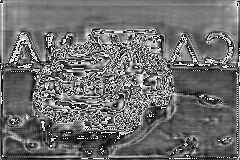

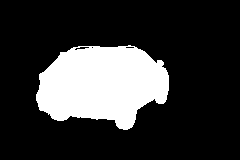

In [141]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Rotate(limit=45, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        A.pytorch.ToTensorV2(),
    ], additional_targets={'mask':'mask'}
)
ds = SegmentationDataset('../input/carvana-image-masking-png/train_images', '../input/carvana-image-masking-png/train_masks', transform)
x, y = ds.__getitem__(2)
x = model(x.unsqueeze(0))

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = tensor.numpy().astype(np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)
img, mask = tensor_to_image(x.detach().squeeze(0).squeeze(0)), tensor_to_image(y.squeeze(0).squeeze(0))
display(img, mask)

In [133]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import albumentations as A
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()
transform = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Rotate(limit=45, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        A.pytorch.ToTensorV2(),
    ]
)
ds = SegmentationDataModule('../input/carvana-image-masking-png/train_images', '../input/carvana-image-masking-png/train_masks', transform=transform)
trainer = pl.Trainer(max_epochs=5, gpus=1)
model = UNET(3, 1)
trainer.fit(model, ds)
trainer.save_checkpoint("unet_segmentation.ckpt")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [137]:
!zip -r lightning_logs.zip ./lightning_logs

  adding: lightning_logs/ (stored 0%)
  adding: lightning_logs/.ipynb_checkpoints/ (stored 0%)
  adding: lightning_logs/version_0/ (stored 0%)
  adding: lightning_logs/version_0/hparams.yaml (stored 0%)
  adding: lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/version_0/checkpoints/epoch=4-step=4580.ckpt (deflated 8%)
  adding: lightning_logs/version_0/events.out.tfevents.1653963410.49cbb67b8661.38.0 (deflated 5%)


<a href='./lightning_logs.zip'>Download Logs</a>